#IS 675 Lab 9: Learning from Images with Convolutions

---


## Butterfly Classification <br>
Train, Test data set for 10 butterfly species. All images are 224 X 224 X 3 in jpg format.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
# Define the image preprocessing pipeline
Butterfly_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # ToTensor() converts images to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=Butterfly_trans)
test_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=Butterfly_trans)

In [ ]:
len(train_butterfly10.classes)

10

In [ ]:
# Examine the sizes of training and test data
print(len(train_butterfly10), len(test_butterfly10))

1175 50


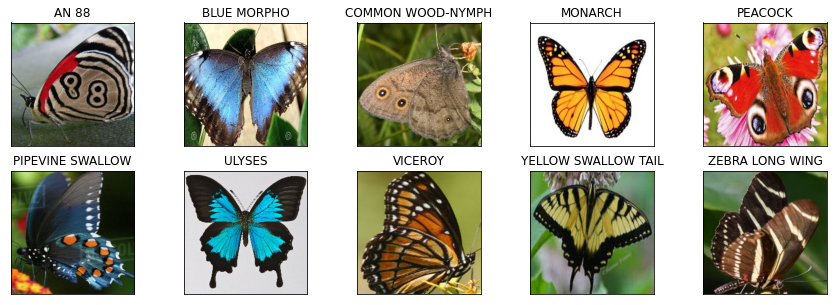

In [ ]:
class_names = ['AN 88','BLUE MORPHO','COMMON WOOD-NYMPH','MONARCH','PEACOCK','PIPEVINE SWALLOW','ULYSES','VICEROY','YELLOW SWALLOW TAIL','ZEBRA LONG WING']

fig = plt.figure(figsize=(15,5))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in test_butterfly10 if label == i)
    if i == 3:
      example_img = img
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
# Examine the tensor of a zebra long wing image
print(img.shape)
print(img)

torch.Size([3, 224, 224])
tensor([[[0.3961, 0.3961, 0.4000,  ..., 0.4353, 0.4275, 0.4314],
         [0.4039, 0.4039, 0.4000,  ..., 0.4314, 0.4235, 0.4196],
         [0.4118, 0.4078, 0.4039,  ..., 0.4431, 0.4353, 0.4275],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.4706, 0.4941, 0.5020],
         [0.0392, 0.0392, 0.0392,  ..., 0.4118, 0.4353, 0.4471],
         [0.0392, 0.0392, 0.0392,  ..., 0.3608, 0.3804, 0.3882]],

        [[0.5294, 0.5294, 0.5333,  ..., 0.5647, 0.5608, 0.5725],
         [0.5373, 0.5373, 0.5333,  ..., 0.5647, 0.5569, 0.5608],
         [0.5451, 0.5412, 0.5373,  ..., 0.5765, 0.5686, 0.5686],
         ...,
         [0.0431, 0.0431, 0.0431,  ..., 0.5647, 0.5882, 0.5961],
         [0.0431, 0.0431, 0.0431,  ..., 0.5216, 0.5451, 0.5569],
         [0.0431, 0.0431, 0.0431,  ..., 0.4745, 0.4941, 0.5020]],

        [[0.3843, 0.3843, 0.3882,  ..., 0.3412, 0.3255, 0.3333],
         [0.3922, 0.3922, 0.3882,  ..., 0.3294, 0.3216, 0.3216],
         [0.4078, 0.4039, 0.4000

#### Convolutions

In [ ]:
#nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output features, and the size of the kernel.
conv = nn.Conv2d(3, 16, kernel_size=3)

In [ ]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
output = conv(example_img)
example_img.shape, output.shape

(torch.Size([3, 224, 224]), torch.Size([16, 222, 222]))

In [ ]:
# Maintain the same image size with padding
conv = nn.Conv2d(3, 16, kernel_size=5, padding=2)

In [ ]:
output = conv(example_img)

output.shape

torch.Size([16, 224, 224])

#### Detecting features with convolutions 

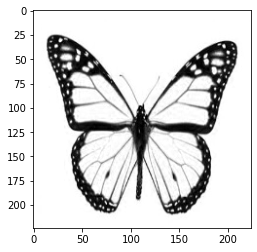

In [ ]:
plt.imshow(example_img[0], cmap='gray')
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

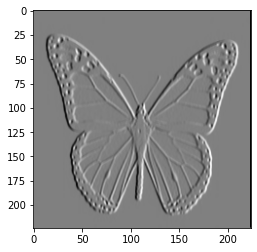

In [ ]:
output = conv(example_img)
plt.imshow(output[0].detach(), cmap='gray')
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, -1.0, -1.0],
                                   [0.0, 0.0, 0.0],
                                   [1.0, 1.0, 1.0]])
    conv.bias.zero_()

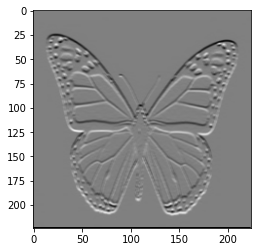

In [ ]:
output = conv(example_img)
plt.imshow(output[0].detach(), cmap='gray')
plt.show()

#### Looking Further with Depth and Pooling

In [ ]:
# Downsample our image
pool = nn.MaxPool2d(4)
output = pool(img)
output.shape

torch.Size([3, 56, 56])

#### Model training and evaluation

In [ ]:
# Examine the mean and std of images in the training data
imgs = torch.stack([img_t for img_t, label in train_butterfly10], dim=3)
print(imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1))

tensor([0.4621, 0.4528, 0.3400]) tensor([0.2884, 0.2767, 0.2862])


In [ ]:
# Define the image preprocessing pipeline to include normalization
Butterfly_trans = transforms.Compose([transforms.Resize((224, 224)), # composes several transforms together
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.4621, 0.4528, 0.3400],std=[0.2884, 0.2767, 0.2862])
                                      ])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=Butterfly_trans)
test_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=Butterfly_trans)

In [ ]:
# Define training and testing data loader, and set batch size to 128
train_loader_butterfly10 = torch.utils.data.DataLoader(train_butterfly10, batch_size=128, shuffle=True)
test_loader_butterfly10 = torch.utils.data.DataLoader(test_butterfly10, batch_size=128, shuffle=False)

In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2), # 8 * 224 * 224
            nn.ReLU(),
            nn.MaxPool2d(4), # 8 * 56 * 56 (224/4 = 56)

            nn.Conv2d(8, 4, kernel_size=5, padding=2), # 4 * 56 * 56
            nn.ReLU(),
            nn.MaxPool2d(4), # 8 * 14 * 14 (56/4 = 14)
            nn.Flatten(), # 
            nn.Linear(4 * 14 * 14, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size))


    def forward(self, x):
        out = self.network(x)
        return out

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training

torch.manual_seed(0)
model = neural_network(32, 10)
optimizer_adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 15, optimizer = optimizer_adam, model = model, loss_fn = loss_fn, train_loader = train_loader_butterfly10)

Epoch 0, Training loss 2.2838610649108886
Epoch 1, Training loss 2.1723225116729736
Epoch 2, Training loss 1.9895537614822387
Epoch 3, Training loss 1.729353392124176
Epoch 4, Training loss 1.4081103444099425
Epoch 5, Training loss 1.2388142824172974
Epoch 6, Training loss 1.0066421538591386
Epoch 7, Training loss 0.9479695975780487
Epoch 8, Training loss 0.8919807195663452
Epoch 9, Training loss 0.7968811690807343
Epoch 10, Training loss 0.6863448143005371
Epoch 11, Training loss 0.6794787049293518
Epoch 12, Training loss 0.6353271067142486
Epoch 13, Training loss 0.5850581586360931
Epoch 14, Training loss 0.532047575712204


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_train.append(predicted.tolist())
          labels_train.append(labels.tolist())

      for inputs, labels in test_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_test.append(predicted.tolist())
          labels_test.append(labels.tolist())

  print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Confusion matrix on test:\n",  confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [ ]:
# Examine evaluation results
test(model, train_loader_butterfly10, test_loader_butterfly10)

Confusion matrix on train:
 [[112   0   1   1   0   0   0   1   4   2]
 [  0  66  22   0   0   1   9   0   2   7]
 [  1   3 112   1   1   0   1   3   5   1]
 [  4   0   1 101   1   0   0  20   2   0]
 [  1   2   1   3 106   0   0   4   2   1]
 [  3   2   8   0   0  95   2   1   5   4]
 [  0   5   3   0   0   0 110   0   1   1]
 [  5   0   4  17   0   0   1  88   0   0]
 [  1   0   1   1   0   5   0   1  94   4]
 [  1   0   4   0   0   0   1   1   1 100]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       121
           1       0.85      0.62      0.71       107
           2       0.71      0.88      0.79       128
           3       0.81      0.78      0.80       129
           4       0.98      0.88      0.93       120
           5       0.94      0.79      0.86       120
           6       0.89      0.92      0.90       120
           7       0.74      0.77      0.75       115
           8       0

### Training on the GPU

**Change the Notebook Settings in Colab**: Edit-> Notebook Settings -> GPU

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
# Define the image preprocessing pipeline to include normalization
Butterfly_trans = transforms.Compose([transforms.Resize((224, 224)), # composes several transforms together
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.4621, 0.4528, 0.3400],std=[0.2884, 0.2767, 0.2862])
                                      ])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=Butterfly_trans)
test_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=Butterfly_trans)

In [ ]:
# Define training and testing data loader, and set batch size to 128
train_loader_butterfly10 = torch.utils.data.DataLoader(train_butterfly10, batch_size=128, shuffle=True)
test_loader_butterfly10 = torch.utils.data.DataLoader(test_butterfly10, batch_size=128, shuffle=False)

In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  hidden_size, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Conv2d(3, 8, kernel_size=5, padding=2), # 8 x 224 x 224 image
          nn.ReLU(),
          nn.MaxPool2d(4), # 8 x 56 x 56 image
          nn.Conv2d(8, 4, kernel_size=3, padding=1), # 4 x 56 x 56 image
          nn.ReLU(),
          nn.MaxPool2d(4), # 4 x 14 x 14 image
          nn.Flatten(), # (-1, 4 * 14 * 14)
          nn.Linear(4 * 14 * 14, hidden_size), # (-1, 32)
          nn.ReLU(),
          nn.Linear(hidden_size, out_size))

    def forward(self, x):
        out = self.network(x)
        return out

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            # These two lines that move inputs and labels to the device we are training on are the only difference from our previous version.
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
model = neural_network(32, 10).to(device=device) # Move our model (all parameters) to the GPU
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 20, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_butterfly10)

Epoch 0, Training loss 2.268310070037842
Epoch 1, Training loss 2.0511712789535523
Epoch 2, Training loss 1.6533527731895448
Epoch 3, Training loss 1.3752445936203004
Epoch 4, Training loss 1.143849354982376
Epoch 5, Training loss 0.9880010604858398
Epoch 6, Training loss 0.871663647890091
Epoch 7, Training loss 0.7904013872146607
Epoch 8, Training loss 0.7404863834381104
Epoch 9, Training loss 0.6248589724302291
Epoch 10, Training loss 0.5778319239616394
Epoch 11, Training loss 0.5721517443656922
Epoch 12, Training loss 0.47951260209083557
Epoch 13, Training loss 0.4280476152896881
Epoch 14, Training loss 0.3896830856800079
Epoch 15, Training loss 0.36878147125244143
Epoch 16, Training loss 0.36335293352603915
Epoch 17, Training loss 0.31429506838321686
Epoch 18, Training loss 0.29438564628362657
Epoch 19, Training loss 0.22802572697401047


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          # These two lines that move inputs and labels to the device we are training on are the only difference from our previous version.
          inputs = inputs.to(device=device)
          labels = labels.to(device=device)

          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_train.append(predicted.tolist())
          labels_train.append(labels.tolist())

      for inputs, labels in test_loader:
          # These two lines that move inputs and labels to the device we are training on are the only difference from our previous version.
          inputs = inputs.to(device=device)
          labels = labels.to(device=device)
          
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_test.append(predicted.tolist())
          labels_test.append(labels.tolist())

  print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Confusion matrix on test:\n",  confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [ ]:
# Examine evaluation results
test(model, train_loader_butterfly10, test_loader_butterfly10)

Confusion matrix on train:
 [[118   2   0   0   0   0   0   0   0   1]
 [  0  94   4   0   1   1   5   1   0   1]
 [  0   2 117   0   3   0   0   1   1   4]
 [  0   0   0 115   0   1   0  13   0   0]
 [  0   0   0   0 119   0   0   1   0   0]
 [  0   1   1   0   0 118   0   0   0   0]
 [  0   1   0   0   0   1 118   0   0   0]
 [  0   0   0   3   1   0   0 111   0   0]
 [  1   0   0   1   1   4   0   1  96   3]
 [  0   0   2   0   0   0   0   0   0 106]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       121
           1       0.94      0.88      0.91       107
           2       0.94      0.91      0.93       128
           3       0.97      0.89      0.93       129
           4       0.95      0.99      0.97       120
           5       0.94      0.98      0.96       120
           6       0.96      0.98      0.97       120
           7       0.87      0.97      0.91       115
           8       0

In [ ]:
# Generate a html file
!jupyter nbconvert --to html "/content/drive/MyDrive/DL_Lab/Lab9_Learning_from_Images_with_Convolutions.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DL_Lab/Lab9_Learning_from_Images_with_Convolutions.ipynb to html
[NbConvertApp] Writing 986746 bytes to /content/drive/MyDrive/DL_Lab/Lab9_Learning_from_Images_with_Convolutions.html
